## Import important libraries and download data 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Install the library using which we can download any file directly using its Google Drive link

In [2]:
pip install gdown

  Created wheel for gdown: filename=gdown-3.10.0-cp36-none-any.whl size=9824 sha256=07e8a3e03aa6909c513981608bff513b192ce08d3878b955aa2fec33591335bd
  Stored in directory: /root/.cache/pip/wheels/45/29/a5/dd3da737c69cb0a46e35ae94e7aa26f2600b4cc7e7b4d4bd44
Successfully built gdown
Note: you may need to restart the kernel to use updated packages.


In [3]:
import gdown

url = 'https://drive.google.com/uc?id=1sDCcgXbby8_v3Z59oRjrh1igEukx8HMI'  

output = 'orbuculum.tar.gz'

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1sDCcgXbby8_v3Z59oRjrh1igEukx8HMI
To: /kaggle/working/orbuculum.tar.gz
36.8MB [00:00, 63.6MB/s]


'orbuculum.tar.gz'

Extract the .tar file to obtain the required data

In [4]:
import tarfile
tar = tarfile.open('/kaggle/working/orbuculum.tar.gz')
tar.extractall()
tar.close()

In [5]:
df = pd.read_csv('/kaggle/working/task/annotation.csv')

## Data Preprocessing

Read all the images and obtain their respective feature arrays.

In [6]:
img_dir = '/kaggle/working/task/data/'
X = []
for image in df['image']:
  img = plt.imread(img_dir + image + '.jpg')
  X.append(img)
X = np.array(X)
X.shape

(1400, 224, 224, 3)

Clean the labels

In [7]:
Targets = df['labels'].apply(lambda x: [item.strip("'") for item in x.strip("[]").split(', ')] )
Targets

0              [bread, pizzoccheri, potatoes, savory_pie]
1                                     [lasagna_bolognese]
2                                     [lasagna_bolognese]
3       [bread, pasta, fillet_fish, potatoes, green_be...
4                              [bread, pasta, meat, peas]
                              ...                        
1395           [lasagna_bolognese, cutlet, fennel_gratin]
1396    [bread, pudding, pasta, fillet_fish, green_bea...
1397                                [pasta, cutlet, peas]
1398    [bread, orange, fennel_gratin, fennel_gratin, ...
1399          [bread, pudding, pizzoccheri, meat, carrot]
Name: labels, Length: 1400, dtype: object

In [8]:
Target_array = np.array(Targets)
Target_array.shape

(1400,)

Binary Encode the labels to obtain an array of size 33 for each image. Even if the labels list of any image contains any repeating values, this encoding still counts it as 1 

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(Target_array)

In [10]:
y.shape

(1400, 33)

In [11]:
mlb.classes_

array(['apple', 'banana', 'bread', 'bruscitt', 'cake', 'carrot', 'cutlet',
       'fennel_gratin', 'fillet_fish', 'fries', 'green_beans',
       'lasagna_bolognese', 'meat', 'orange', 'pasta', 'pears', 'peas',
       'pizza', 'pizzoccheri', 'potatoes', 'pudding', 'rice', 'salad',
       'salmon', 'salty_cake', 'savory_pie', 'scallops', 'soup',
       'spinach', 'squid_stew', 'tangerine', 'wet_zucchini', 'yogurt'],
      dtype=object)

Scale all the values between 0 and 1 for the input ndarray. 

In [12]:
X_scaled = X/255

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_held_out, y_train, y_held_out = train_test_split(X_scaled, y, test_size=0.3, random_state = 42)

The held out set has 30% of total dnumber of samples. So, we further split it into two to obtain the validation and test sets.

In [14]:
i = int(0.5*X_held_out.shape[0])

X_valid = X_held_out[:i]
X_test = X_held_out[i:]

y_valid = y_held_out[:i]
y_test = y_held_out[i:]

## Build and Train a CNN model using Keras with Tensorflow backend

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, concatenate, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [313]:
input = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))

conv1a = Conv2D(filters = 16, kernel_size = (3, 3), padding='same')(input)
conv1b = Conv2D(filters = 16, kernel_size = (5, 5), padding='same')(input)
conv1c = Conv2D(filters = 16, kernel_size = (7, 7), padding='same')(input)
conv1d = Conv2D(filters = 16, kernel_size = (11, 11), padding='same')(input)

merged = concatenate([conv1a, conv1b, conv1c, conv1d], axis=-1)
norm1 = BatchNormalization()(merged)
act1 = Activation('relu')(norm1)
pool1 = MaxPooling2D(pool_size=(2, 2))(act1)

conv2 = Conv2D(filters = 16, kernel_size = (3, 3))(pool1)
norm2 = BatchNormalization()(conv2)
act2 = Activation('relu')(norm2)
pool2 = MaxPooling2D(pool_size=(2, 2))(act2)

conv3 = Conv2D(filters = 32, kernel_size = (3, 3))(pool2)
norm3 = BatchNormalization()(conv3)
act3 = Activation('relu')(norm3)
pool3 = MaxPooling2D(pool_size=(2, 2))(act3)

conv4 = Conv2D(filters = 32, kernel_size = (3, 3))(pool3)
norm4 = BatchNormalization()(conv4)
act4 = Activation('relu')(norm4)
pool4 = MaxPooling2D(pool_size=(2, 2))(act4)

conv5 = Conv2D(filters = 64, kernel_size = (3, 3))(pool4)
norm5 = BatchNormalization()(conv5)
act5 = Activation('relu')(norm5)
pool5 = MaxPooling2D(pool_size=(2, 2))(act5)

flatten = Flatten()(pool5)

hidden1 = Dense(1024, activation='relu')(flatten)
drop1 = Dropout(0.5)(hidden1)

hidden2 = Dense(512, activation='relu')(drop1)
drop2 = Dropout(0.5)(hidden2)

output= Dense(y_train.shape[1], activation='sigmoid')(drop2)

model = Model(input, output)

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 224, 224, 16) 448         input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 224, 224, 16) 1216        input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_118 (Conv2D)             (None, 224, 224, 16) 2368        input_16[0][0]                   
___________________________________________________________________________________________

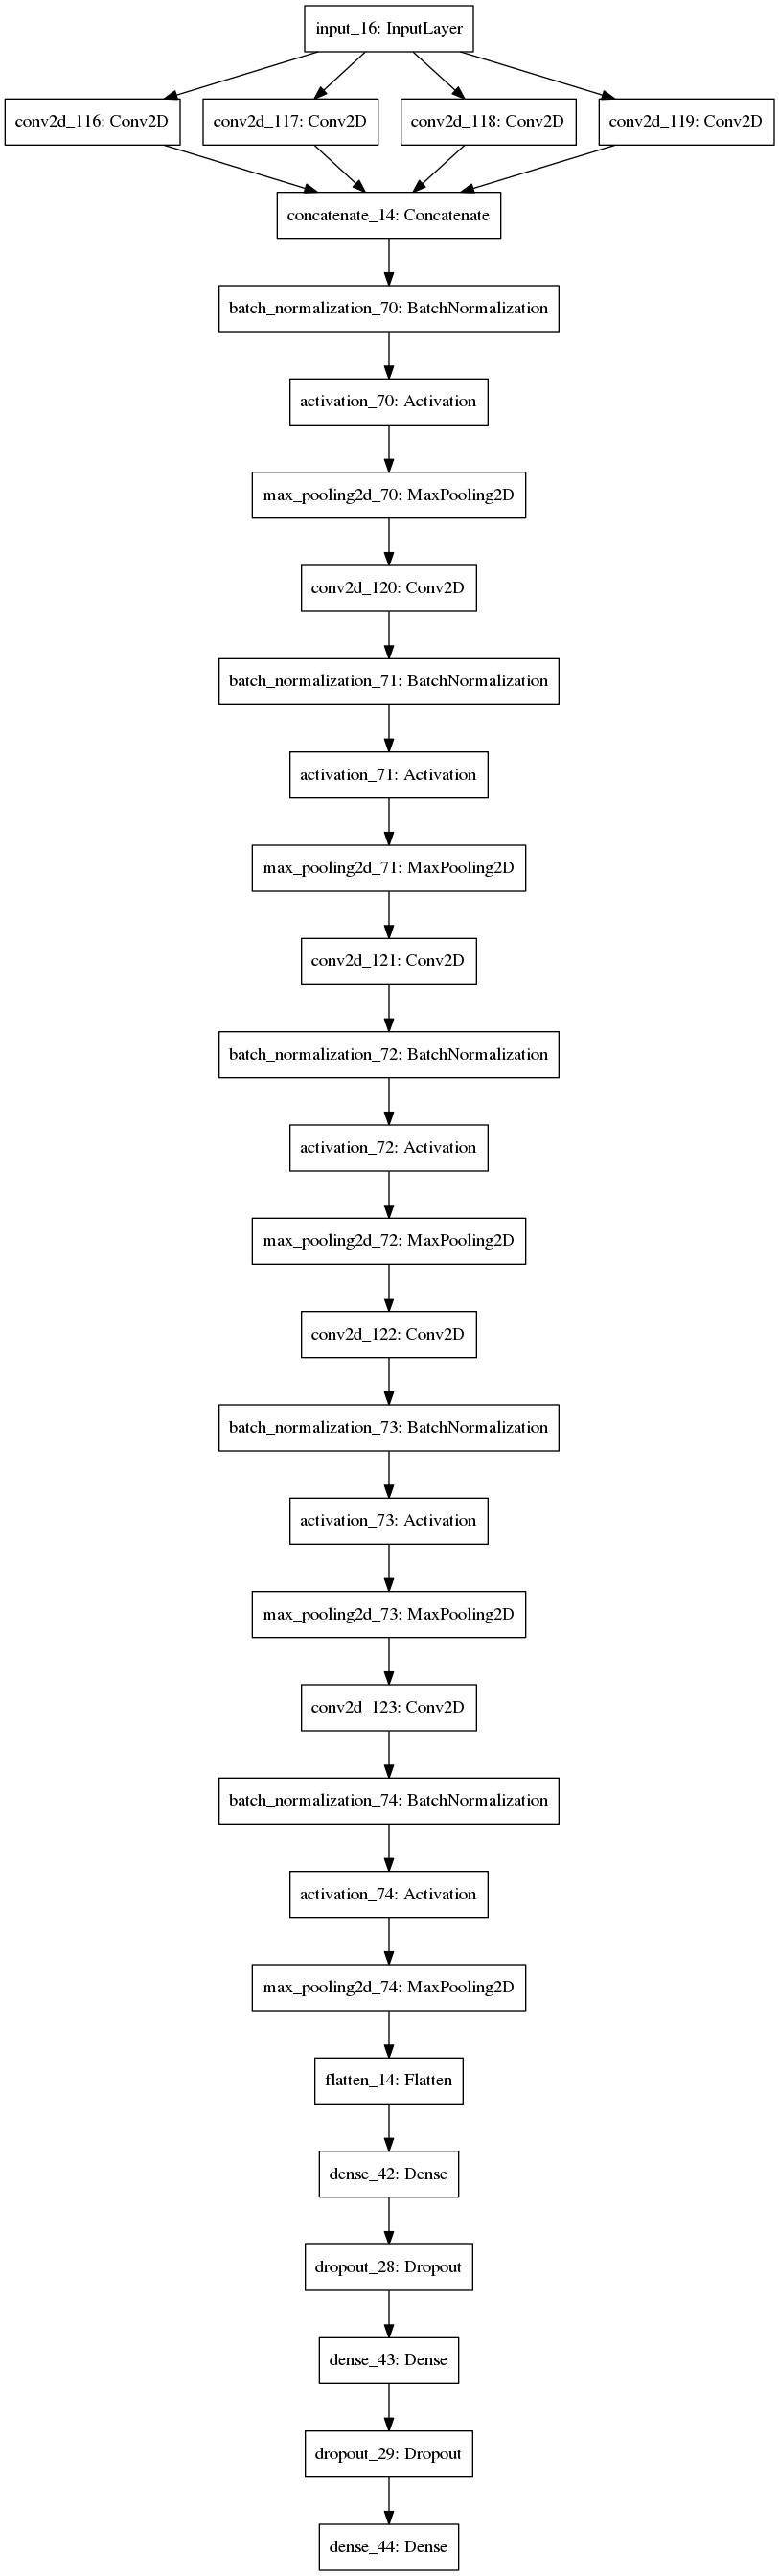

In [314]:
from tensorflow.keras.utils import plot_model
plot_model(model)

Define and add f1_score as a metric[](http://)

In [315]:
import tensorflow.keras.backend as K

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [316]:
model.compile(optimizer=Adam(0.0005), loss='binary_crossentropy', metrics=[f1_score])

Save the model weights that give the minimum validation loss during training, (checked after every epoch)

In [317]:
save_at = "/kaggle/working/model.hdf5"
save_best = ModelCheckpoint(save_at, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min')

In [318]:
history = model.fit( X_train, y_train, 
                    epochs = 25, batch_size = 8, 
                    callbacks=[save_best], verbose=1, 
                    validation_data = (X_valid, y_valid))

Train on 980 samples, validate on 210 samples
Epoch 1/25
980/980 [==============================] - 5s 5ms/sample - loss: 0.3911 - f1_score: 0.2250 - val_loss: 0.3315 - val_f1_score: 0.2159
Epoch 2/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.3239 - f1_score: 0.2341 - val_loss: 0.3096 - val_f1_score: 0.0000e+00
Epoch 3/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.3157 - f1_score: 0.2518 - val_loss: 0.3306 - val_f1_score: 0.0021
Epoch 4/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.3071 - f1_score: 0.2551 - val_loss: 0.2873 - val_f1_score: 0.1376
Epoch 5/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.3022 - f1_score: 0.2624 - val_loss: 0.2867 - val_f1_score: 0.1884
Epoch 6/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.2967 - f1_score: 0.2852 - val_loss: 0.2952 - val_f1_score: 0.2678
Epoch 7/25
980/980 [==============================] - 3s 3ms/sample - loss: 0.2899 - f

Save the training logs to a text file

In [319]:
hist_df = pd.DataFrame(history.history) 
hist_df.index.rename('epoch', inplace=True)
logs = open('logs.txt', 'a')
logs.write(hist_df.to_string())
logs.close()

## Evaluation of Model's Performance

Plot the training and validation loss against epoch

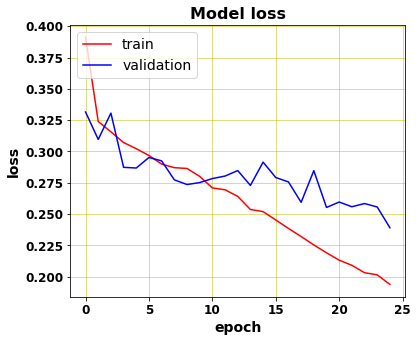

<Figure size 432x288 with 0 Axes>

In [335]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model loss', weight='bold', fontsize=16)
plt.ylabel('loss', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()
plt.savefig('loss.png')

Plot the training and validation f1 score against epoch

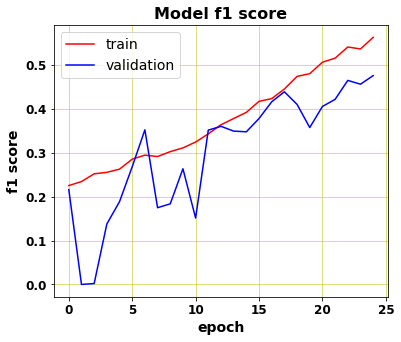

<Figure size 432x288 with 0 Axes>

In [336]:
plt.figure(figsize=(6, 5))
plt.plot(history.history['f1_score'], color='r')
plt.plot(history.history['val_f1_score'], color='b')
plt.title('Model f1 score', weight='bold', fontsize=16)
plt.ylabel('f1 score', weight='bold', fontsize=14)
plt.xlabel('epoch', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12)
plt.yticks(weight='bold', fontsize=12)
plt.legend(['train', 'validation'], loc='upper left', prop={'size': 14})
plt.grid(color = 'y', linewidth='0.5')
plt.show()
plt.savefig('f1.png')

Since the values in the predictions made by the trained model are between 0 and 1, we need to determine the threshold to keep which will give the max f1_score

In [322]:
from sklearn.metrics import f1_score
scores = []
y_hat = model.predict(X_test)
threshold = 0
for i in range(100):
    y_pred = np.copy(y_hat)
    y_pred[y_pred < threshold] = 0
    y_pred[y_pred >= threshold] = 1
    scores.append(f1_score(y_test, y_pred, average='samples'))
    threshold += 0.01

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [323]:
max(scores)

0.4894495980210266

In [324]:
threshold = scores.index(max(scores))/100
threshold

0.36

In [325]:
y_final = np.copy(y_hat)
y_final[y_final < threshold] = 0
y_final[y_final >= threshold] = 1

Pick 10 images at random from the test set and plot them with their true and predicted 

In [326]:
classified_labels = []
for i in range(len(y_final)):
    classified_labels.append(mlb.classes_[(y_final == 1)[i]])

In [327]:
actual_labels = []
for i in range(len(y_test)):
    actual_labels.append(mlb.classes_[(y_test == 1)[i]])

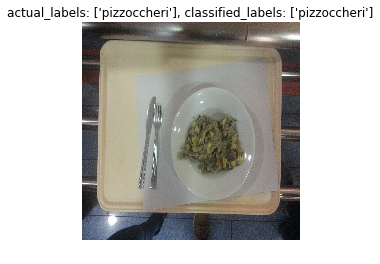

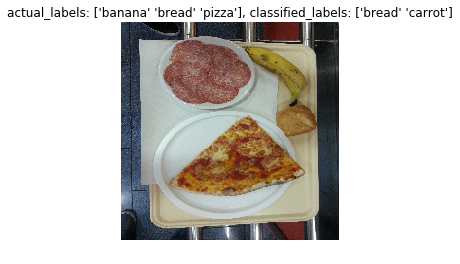

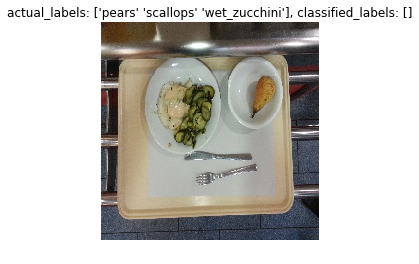

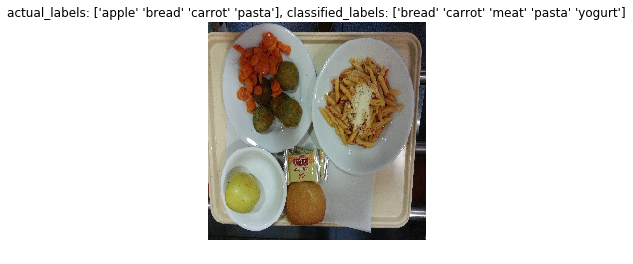

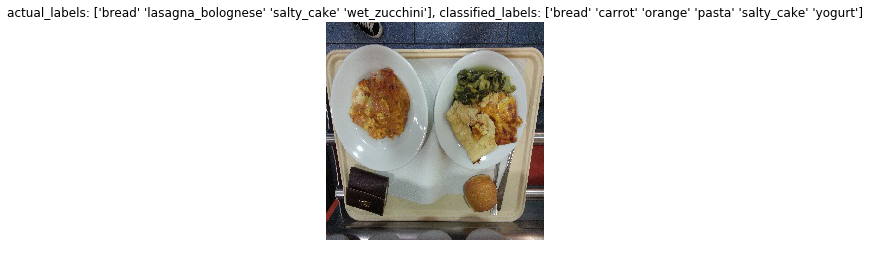

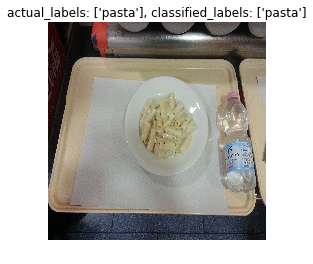

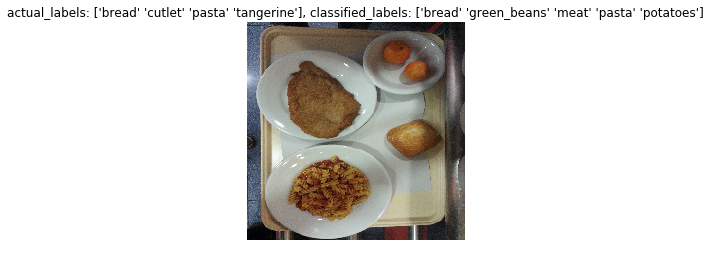

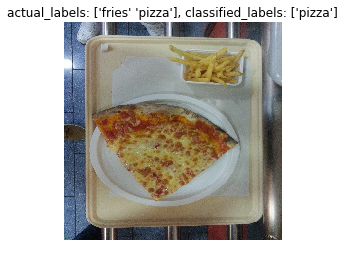

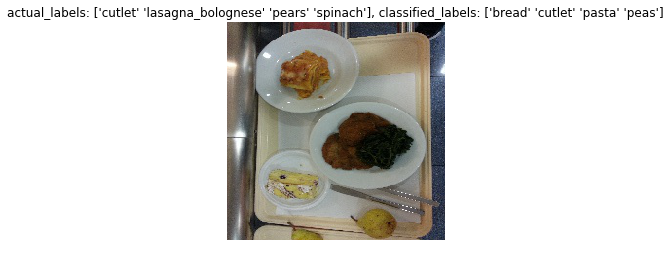

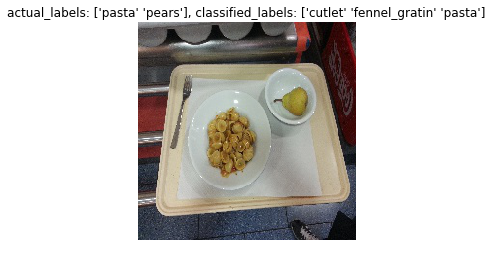

In [328]:
np.random.seed(49)
random_samples = np.random.randint(0, len(X_test), 10)
for sample in random_samples:
    img  = X_test[sample]
    plt.figure()
    plt.imshow(img),plt.axis('off')
    plt.title('actual_labels: {}, classified_labels: {}'.format(actual_labels[sample], classified_labels[sample]))

The trained model seems to detect many food items correctly but it also makes many incorrect detections. Let us see for how many sample in the test set, it detected all food items with 100% precision.

In [329]:
perfect_prediction = 0
for i in range(y_final.shape[0]):
    if np.array_equal(y_final[i], y_test[i]):
        perfect_prediction += 1
        
perfect_prediction

13

A look at the confusion matrix will give a clearer picture.

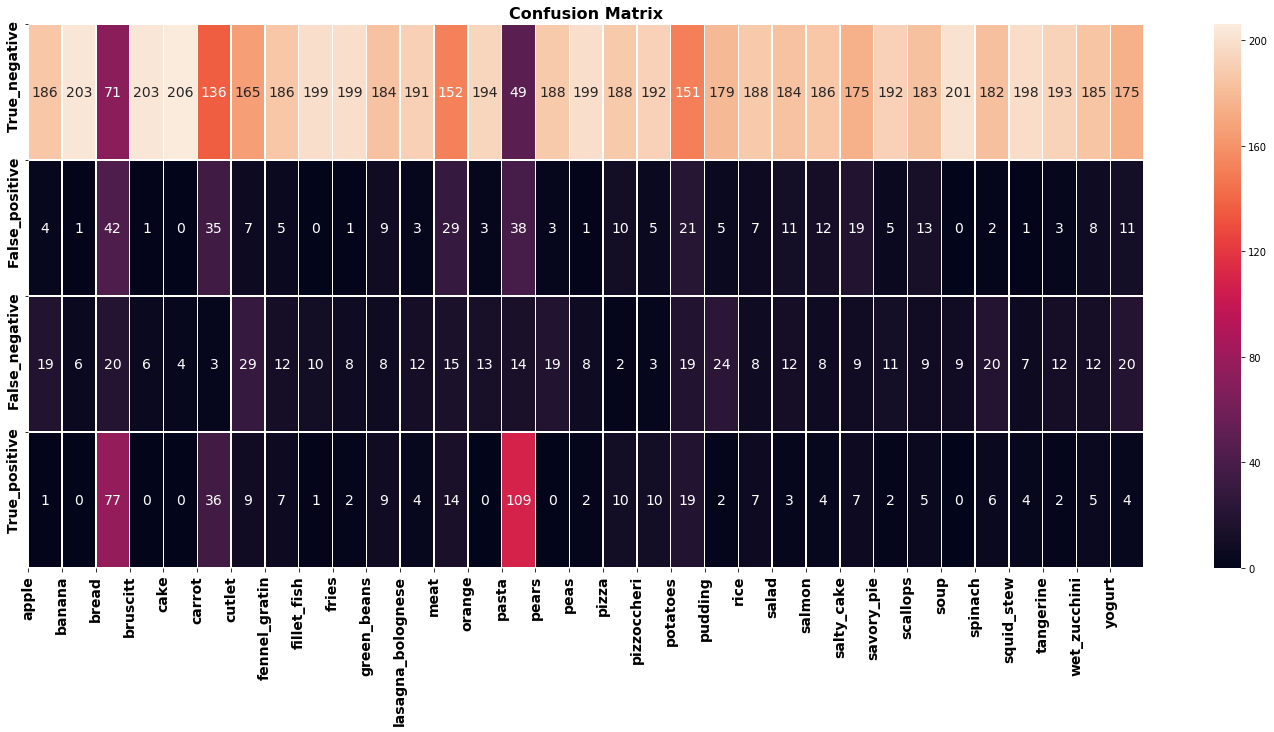

In [337]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
matrix = multilabel_confusion_matrix(y_test, y_final)
plt.figure(figsize=(25, 10))
sns.heatmap(matrix.reshape(33, 4).T,annot=True,cbar=True, fmt='d', linewidths=.5, annot_kws={"fontsize":14})
plt.yticks(np.arange(4), ('True_negative', 'False_positive', 'False_negative', 'True_positive'), weight='bold', fontsize=14)
plt.xticks(np.arange(33), tuple(mlb.classes_), weight='bold', fontsize=14, rotation=90)
plt.title('Confusion Matrix', weight='bold', fontsize=16)
plt.savefig('confusion.png')

The model seems to do well for some food items than others. Let us check the frequency of food items in the labels to see if model fared better on those items which it had seen more while training.

In [331]:
label_count = np.zeros(mlb.classes_.shape[0])
for item in mlb.inverse_transform(y):
    for item in item:
        label_count[list(mlb.classes_).index(item)] += 1

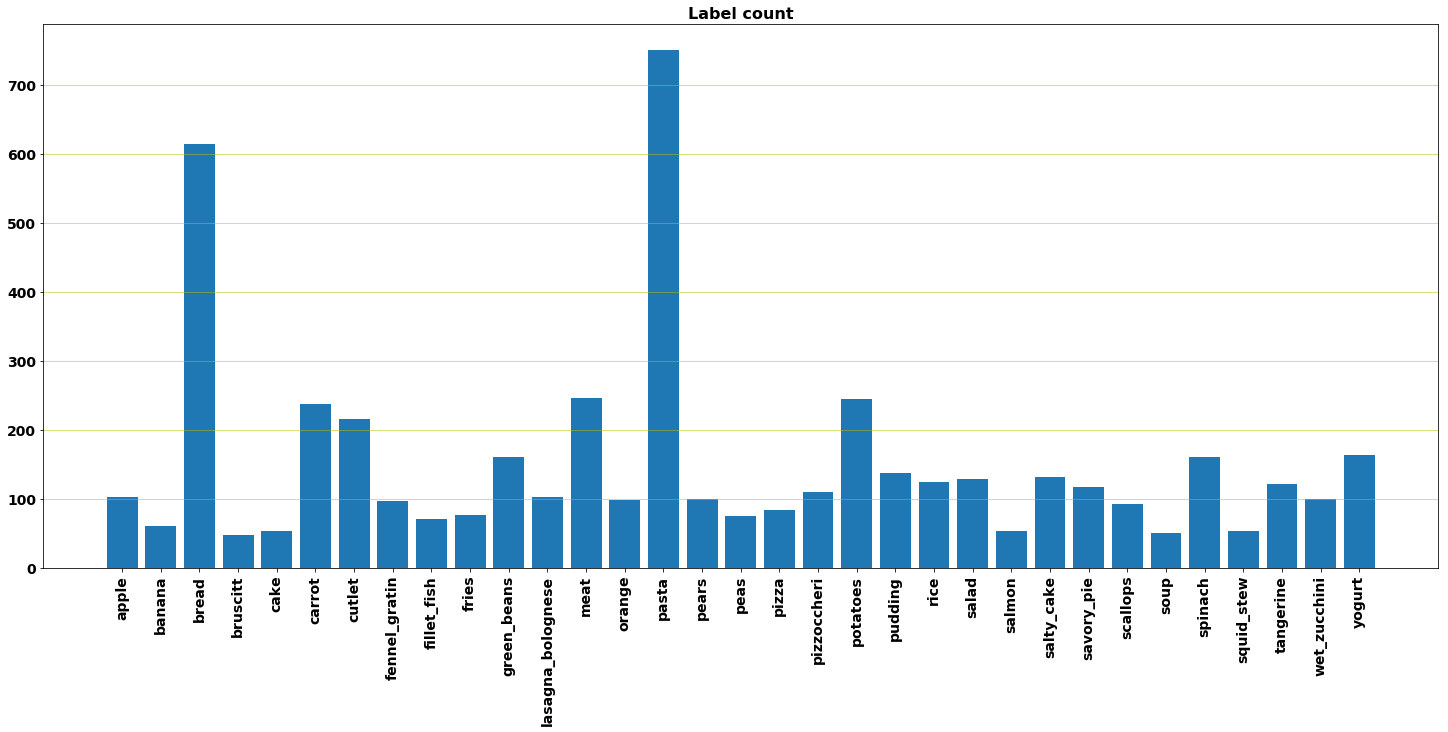

In [332]:
plt.figure(figsize=(25, 10))
plt.bar(list(mlb.classes_), height=label_count)
plt.yticks(weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=14, rotation=90)
plt.title('Label count', weight='bold', fontsize=16)
plt.grid(axis= 'y', color='y', linewidth=0.5)
plt.savefig('label_count.png')

Finally, let us see the food wise classification metrics

In [334]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_final, output_dict=True)
report = pd.DataFrame(report).T

new_index = list(mlb.classes_)
for item in report.index[33:]:
    new_index.append(item)
    
report.index = new_index
report.to_csv('/kaggle/working/report.csv')
report

,precision,recall,f1-score,support
apple,0.200000,0.050000,0.080000,20.0
banana,0.000000,0.000000,0.000000,6.0
bread,0.647059,0.793814,0.712963,97.0
bruscitt,0.000000,0.000000,0.000000,6.0
cake,0.000000,0.000000,0.000000,4.0
carrot,0.507042,0.923077,0.654545,39.0
cutlet,0.562500,0.236842,0.333333,38.0
fennel_gratin,0.583333,0.368421,0.451613,19.0
fillet_fish,1.000000,0.090909,0.166667,11.0
fries,0.666667,0.200000,0.307692,10.0
